In [3]:
import os
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks
import mne

RECORDS = ['r01', 'r04', 'r07', 'r08', 'r10']
fs = 1000  # Hz
window_len = 5000  # 5 seconds at 1000 Hz

def preprocess_signal(signal):
    b_notch, a_notch = iirnotch(50/(fs/2), Q=30)
    b_band, a_band = butter(4, [3/(fs/2), 90/(fs/2)], btype='band')
    signal = filtfilt(b_notch, a_notch, signal)
    signal = filtfilt(b_band, a_band, signal)
    return signal

X_all = []
y_all = []

for rec in RECORDS:
    path = f"C:/Users/KIIT/Desktop/VS_Code/GitHub/Major_Project/data/adfecgdb/{rec}.edf"
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    sig = raw.get_data()  # (5, n_samples)
    sig = np.array([preprocess_signal(ch) for ch in sig[:4]])  # first 4 = abdominal ECG
    sig = sig.T  # shape = (n_samples, 4)

    # Segment into non-overlapping windows
    num_windows = sig.shape[0] // window_len
    for i in range(num_windows):
        win = sig[i*window_len:(i+1)*window_len]
        if win.shape[0] < window_len: continue

        # Derive label from direct fetal ECG (channel 5)
        fetal_ecg = raw.get_data()[4]  # direct fetal scalp ECG
        fetal_win = fetal_ecg[i*window_len:(i+1)*window_len]
        peaks, _ = find_peaks(fetal_win, distance=fs/2)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / fs
            fhr = 60 / np.mean(rr_intervals)
        else:
            fhr = 0
        label = 0 if 110 <= fhr <= 160 else 1  # normal vs abnormal
        X_all.append(win)
        y_all.append(label)

X_all = np.array(X_all)  # shape (n_windows, 5000, 4)
y_all = np.array(y_all)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Normalize each window (channel-wise z-score)
scaler = StandardScaler()
X_all_reshaped = X_all.reshape(-1, 4)
X_all_scaled = scaler.fit_transform(X_all_reshaped).reshape(X_all.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_all_scaled, y_all, test_size=0.2, stratify=y_all, random_state=42
)


For Below code 5-10 epochs are good.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(5000, 4)),  # 5000 time steps, 4 channels
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=6, batch_size=16)


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8829 - loss: 0.6311 - val_accuracy: 0.9833 - val_loss: 0.5208
Epoch 2/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 929ms/step - accuracy: 0.9841 - loss: 0.4512 - val_accuracy: 0.9833 - val_loss: 0.1952
Epoch 3/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 947ms/step - accuracy: 0.9837 - loss: 0.1436 - val_accuracy: 0.9833 - val_loss: 0.0906
Epoch 4/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 949ms/step - accuracy: 0.9853 - loss: 0.0754 - val_accuracy: 0.9833 - val_loss: 0.0909
Epoch 5/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 938ms/step - accuracy: 0.9817 - loss: 0.0789 - val_accuracy: 0.9833 - val_loss: 0.0873
Epoch 6/6
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 929ms/step - accuracy: 0.9877 - loss: 0.0577 - val_accuracy: 0.9833 - val_loss: 0.0870


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Accuracy: 0.9833333333333333
Precision: 0.9833333333333333
Recall: 1.0
F1 Score: 0.9915966386554622


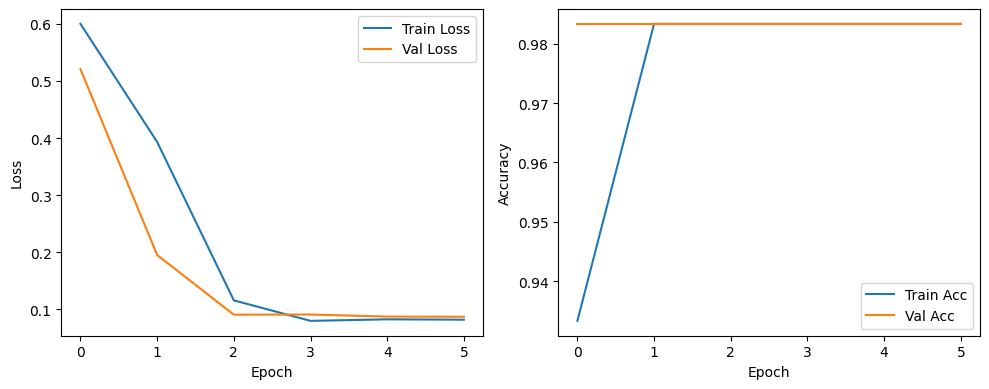

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.tight_layout(); plt.show()


In [10]:
model.save(r'C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\fetal_ecg_lstm_model.h5')